# 1.このSprintについて

Sprintの目的
コンピュータビジョンの代表的タスクであるセグメンテーションを学ぶ

どのように学ぶか
公開されている実装を用いてKaggleコンペティションのデータでセグメンテーションを行います。



# 2.セグメンテーション

KaggleのTGS Salt Identification Challengeのデータセットを使用し、セグメンテーションを行います。


TGS Salt Identification Challenge | Kaggle


セグメンテーション手法としてU-Net[1]を使います。


[1]O.Ronneberger, P.Fischer, T.Brox. U-Net: Convolutional Networks for Biomedical Image Segmentation. Medical Image Computing and Computer-Assisted Intervention (MICCAI), Springer, LNCS, Vol.9351: 234–241, 2015


In [ ]:
!nvidia-smi

Fri Oct  2 04:06:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

2.3.0
2.4.3


In [ ]:
import os
import shutil

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [10]:
cd /content/drive/My Drive/Sprintセグメ1

/content/drive/My Drive/Sprintセグメ1


# 【問題1】学習・推定
以下のKeras実装を使用して学習・推定を行ってください。


zhixuhao/unet: unet for image segmentation


《GPU環境での学習》


大規模なデータセット、大きなモデルになるため、GPUを使用する必要があります。


《新たなデータセットの適用》


公開されている実装で用意されたものとは異なるデータセットを入力するための準備が必要です。

In [ ]:
# !git clone https://github.com/zhixuhao/unet.git

In [9]:
cd unet

/content/drive/My Drive/Sprintセグメ1/unet


In [6]:
from model import unet
from data import trainGenerator
from data import testGenerator
from data import adjustData
from data import saveResult
from data import labelVisualize
from keras.callbacks import ModelCheckpoint

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'./competition_data/train','images','masks',data_gen_args,save_to_dir = None)
# myGene = trainGenerator(2,'data/membrane/train','image','label',data_gen_args,save_to_dir = None)

model = unet()
model_checkpoint = ModelCheckpoint('unet_competition_data.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=2000,epochs=5,callbacks=[model_checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Found 4000 images belonging to 1 classes.
Found 4000 images belonging to 1 classes.
Epoch 1/5
2000/2000 [==============================] - ETA: 0s - loss: 0.5380 - accuracy: 0.7507
Epoch 00001: loss improved from inf to 0.53802, saving model to unet_competition_data.hdf5
2000/2000 [==============================] - 5613s 3s/step - loss: 0.5380 - accuracy: 0.7507
Epoch 2/5
2000/2000 [==============================] - ETA: 0s - loss: 0.4215 - accuracy: 0.8123
Epoch 00002: loss improved from 0.53802 to 0.42147, saving model to unet_competition_data.hdf5
2000/2000 [==============================] - 177s 88ms/step - loss: 0.4215 - accuracy: 0.8123
Epoch 3/5
2000/2000 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.8635
Epoch 00003: loss improved from 0.42147 to 0.37958, saving model to unet_competition_data.hdf5
2000/2000 [==============================] - 177s 88ms/step - loss: 0.3796 - accu

In [ ]:
files = os.listdir("./competition_data/test/images")
num_image = len(files)
num_image

18000

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
testGene = testGenerator("./competition_data/test/images", num_image=num_image)
model = unet()
model.load_weights("unet_competition_data.hdf5")
results = model.predict_generator(testGene, num_image, verbose=1)
saveResult("./competition_data/test/images_pred",results)

18000/18000 [==============================] - 301s 17ms/step


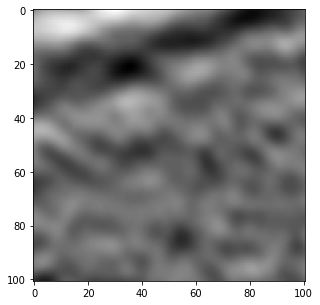

In [14]:
import matplotlib.pyplot as plt
import glob 
from PIL import Image

#セグメンテーション前のtestデータを表示
img__list = glob.glob("/content/drive/My Drive/Sprintセグメ1/unet/competition_data/test/images/*")

with Image.open(img__list[0]) as img:
    plt.rcParams['figure.figsize'] = (5.0, 5.0)
    plt.imshow(img)
    plt.show()

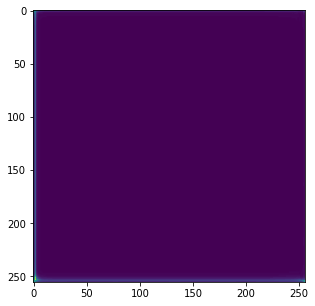

In [15]:
#セグメンテーション後のtestデータを表示
img__list = glob.glob("/content/drive/My Drive/Sprintセグメ1/unet/competition_data/test/images_pred/*")

with Image.open(img__list[0]) as img:
    plt.rcParams['figure.figsize'] = (5.0, 5.0)
    plt.imshow(img)
    plt.show()

### セグメンテーションは出来ていないが、学習・推定は完了した。

# 【問題2】コードリーディング
論文[1]に目を通した上で、上記実装のコードリーディングを行ってください。

- 全層畳み込みネットワーク (Fully Convolution Network)


- skip-conectionを用いて畳み込みによって失われる位置情報を保持する<br>
model.py 34行目　etc.<br>
merge6 = concatenate([drop4,up6], axis = 3)